In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-sales-dataset-popular-marketplace-data/Online Sales Data.csv


Initialize libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

In [3]:
path=r"/kaggle/input/online-sales-dataset-popular-marketplace-data/Online Sales Data.csv"
df=pd.read_csv(path)

In [4]:
df.head()

,Transaction ID,Date,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal


**CLEANING AND PROCESING**

In [5]:
df.info

<bound method DataFrame.info of      Transaction ID        Date Product Category  \
0             10001  2024-01-01      Electronics   
1             10002  2024-01-02  Home Appliances   
2             10003  2024-01-03         Clothing   
3             10004  2024-01-04            Books   
4             10005  2024-01-05  Beauty Products   
..              ...         ...              ...   
235           10236  2024-08-23  Home Appliances   
236           10237  2024-08-24         Clothing   
237           10238  2024-08-25            Books   
238           10239  2024-08-26  Beauty Products   
239           10240  2024-08-27           Sports   

                                        Product Name  Units Sold  Unit Price  \
0                                      iPhone 14 Pro           2      999.99   
1                                   Dyson V11 Vacuum           1      499.99   
2                                   Levi's 501 Jeans           3       69.99   
3                      

In [6]:
df.dtypes

Transaction ID        int64
Date                 object
Product Category     object
Product Name         object
Units Sold            int64
Unit Price          float64
Total Revenue       float64
Region               object
Payment Method       object
dtype: object

In [7]:
missing_values = df.isnull().sum()
print("missing values by columns:")
print(missing_values)

missing values by columns:
Transaction ID      0
Date                0
Product Category    0
Product Name        0
Units Sold          0
Unit Price          0
Total Revenue       0
Region              0
Payment Method      0
dtype: int64


In [8]:
if 'Date' in df.index.names:
    df.reset_index(inplace=True)

In [9]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [10]:
df.head()

,Transaction ID,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method
Date,,,,,,,,
2024-01-01,10001,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
2024-01-02,10002,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2024-01-03,10003,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
2024-01-04,10004,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
2024-01-05,10005,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal


**Insights:
1. Analyze sales trends over time to identify seasonal patterns or growth opportunities.**

In [11]:
monthly_sales = df['Units Sold'].resample('M').sum()

# Display the first rows of monthly sales
print(monthly_sales.head())

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.use_inf_as_na', False)

Date
2024-01-31    68
2024-02-29    77
2024-03-31    82
2024-04-30    65
2024-05-31    60
Freq: ME, Name: Units Sold, dtype: int64


/tmp/ipykernel_17/99529095.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Units Sold'].resample('M').sum()


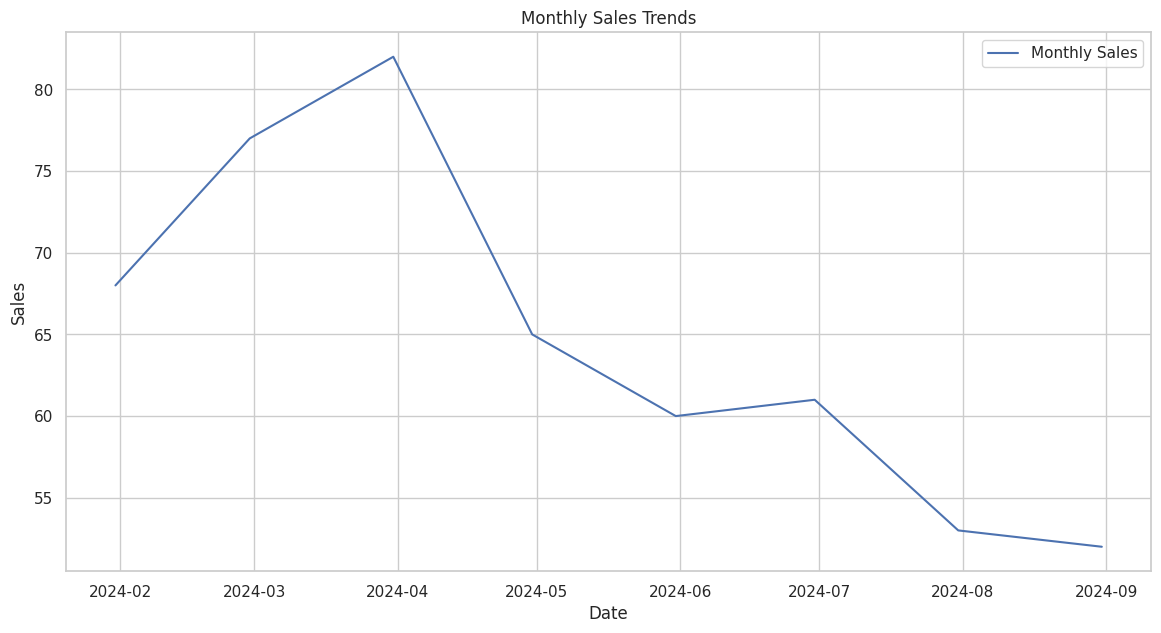

In [12]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales, label='Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales Trends')
plt.legend()
plt.show()
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.use_inf_as_na', False)

* Significant Sales Increase (Months 2 to 4): During this period, a notable increase in sales is observed. This increase could be related to a peak season, a successful marketing campaign, or the introduction of new products or promotions.

* Abrupt Sales Decline (Months 4 to 7): Following the peak in month 4, sales experience a significant and abrupt decline. This could be due to various factors such as changes in market demand, adverse economic conditions, supply issues, or even seasonal changes affecting the demand for certain products.

* Recovery Attempt (Months 7 to 8): A slight uptick in sales is observed in month 7, however, these efforts seem to have been insufficient to reverse the downward trend as sales continue to decline.

In summary, the graph shows a sales pattern characterized by an initial increase followed by a steep decline and subsequent recovery attempts that fail to sustain the previous growth. This analysis suggests that it may be important to investigate the causes behind these changes in sales and take appropriate measures to address the identified challenges.








**2. Explore the popularity of different product categories across regions.**

In [13]:
category_sales_region = df.groupby(['Product Category', 'Region'])['Units Sold'].sum().reset_index()
table_pivot = category_sales_region.pivot(index='Product Category', columns='Region', values='Units Sold')

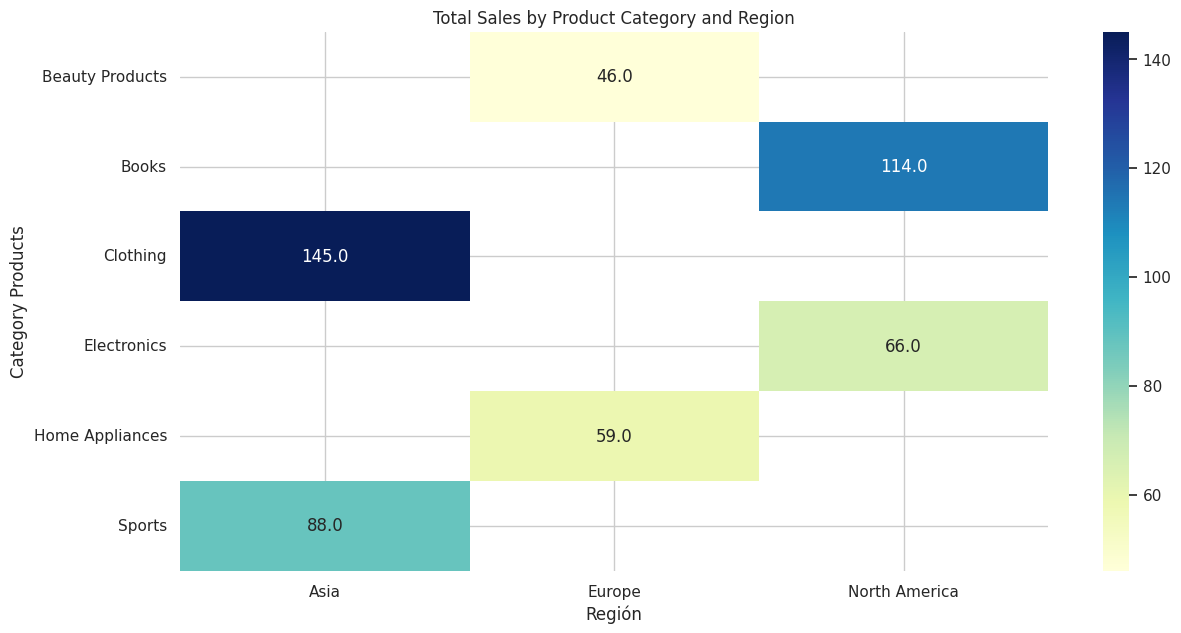

In [14]:
plt.figure(figsize=(14, 7))
sns.heatmap(table_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Total Sales by Product Category and Region')
plt.xlabel('Región')
plt.ylabel('Category Products')
plt.show()

The last graphics illustrate the differences in product categories across Asia, Europe, and North America. It's evident that the market varies significantly in each region.

**3. Investigate the impact of payment methods on sales volume or revenue.**

In [15]:
sales_by_payment = df.groupby('Payment Method')['Total Revenue'].sum().sort_values(ascending=False)

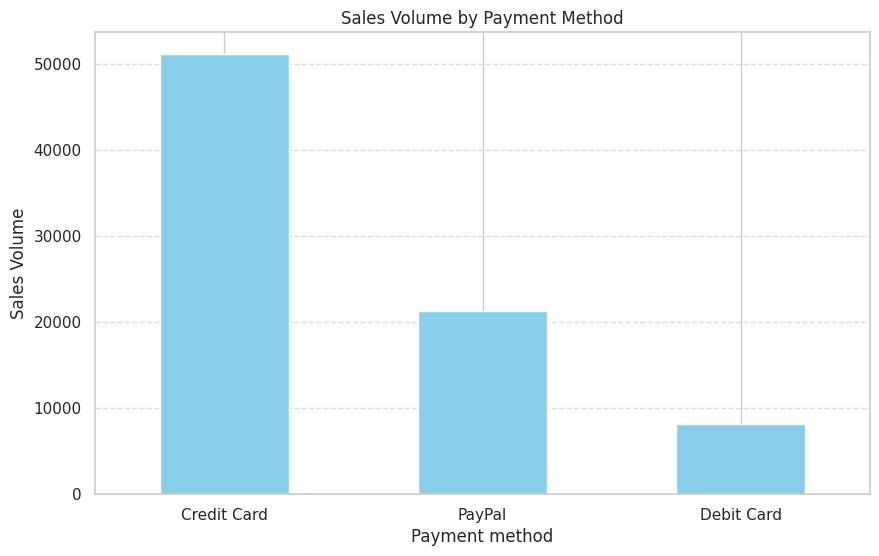

In [16]:
plt.figure(figsize=(10, 6))
sales_by_payment.plot(kind='bar', color='skyblue')
plt.title('Sales Volume by Payment Method')
plt.xlabel('Payment method')
plt.ylabel('Sales Volume')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

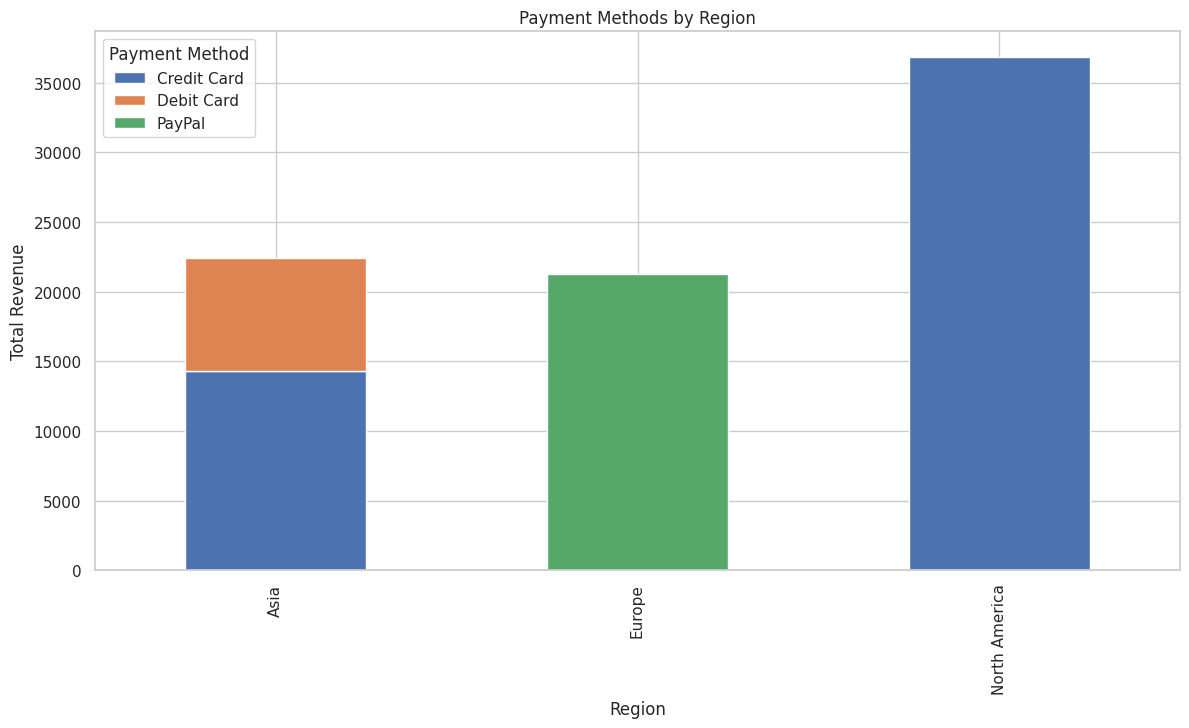

In [17]:
payment_region_sales = df.groupby(['Region', 'Payment Method'])['Total Revenue'].sum().unstack()
payment_region_sales.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Payment Methods by Region')
plt.xlabel('Region')
plt.ylabel('Total Revenue')
plt.legend(title='Payment Method')
plt.show()

Analisys:
* The absence of other payment methods such as cash or bank transfer might suggest that your customers prefer electronic transactions and have a preference for using credit cards.

* It could indicate that your customers have easy access to credit cards and use them as their primary method of payment for purchases.

* If your business offers incentives or special benefits for those who use credit cards, such as reward points or loyalty programs, the trend towards exclusive use of credit cards could indicate that these strategies are effective in encouraging customer spending.

In summary, if all transactions are conducted with credit cards, it could indicate a general preference for the convenience, security, and associated benefits of using credit cards for making purchases.

**4. Identify top-selling products within each category to optimize inventory and marketing strategies**.

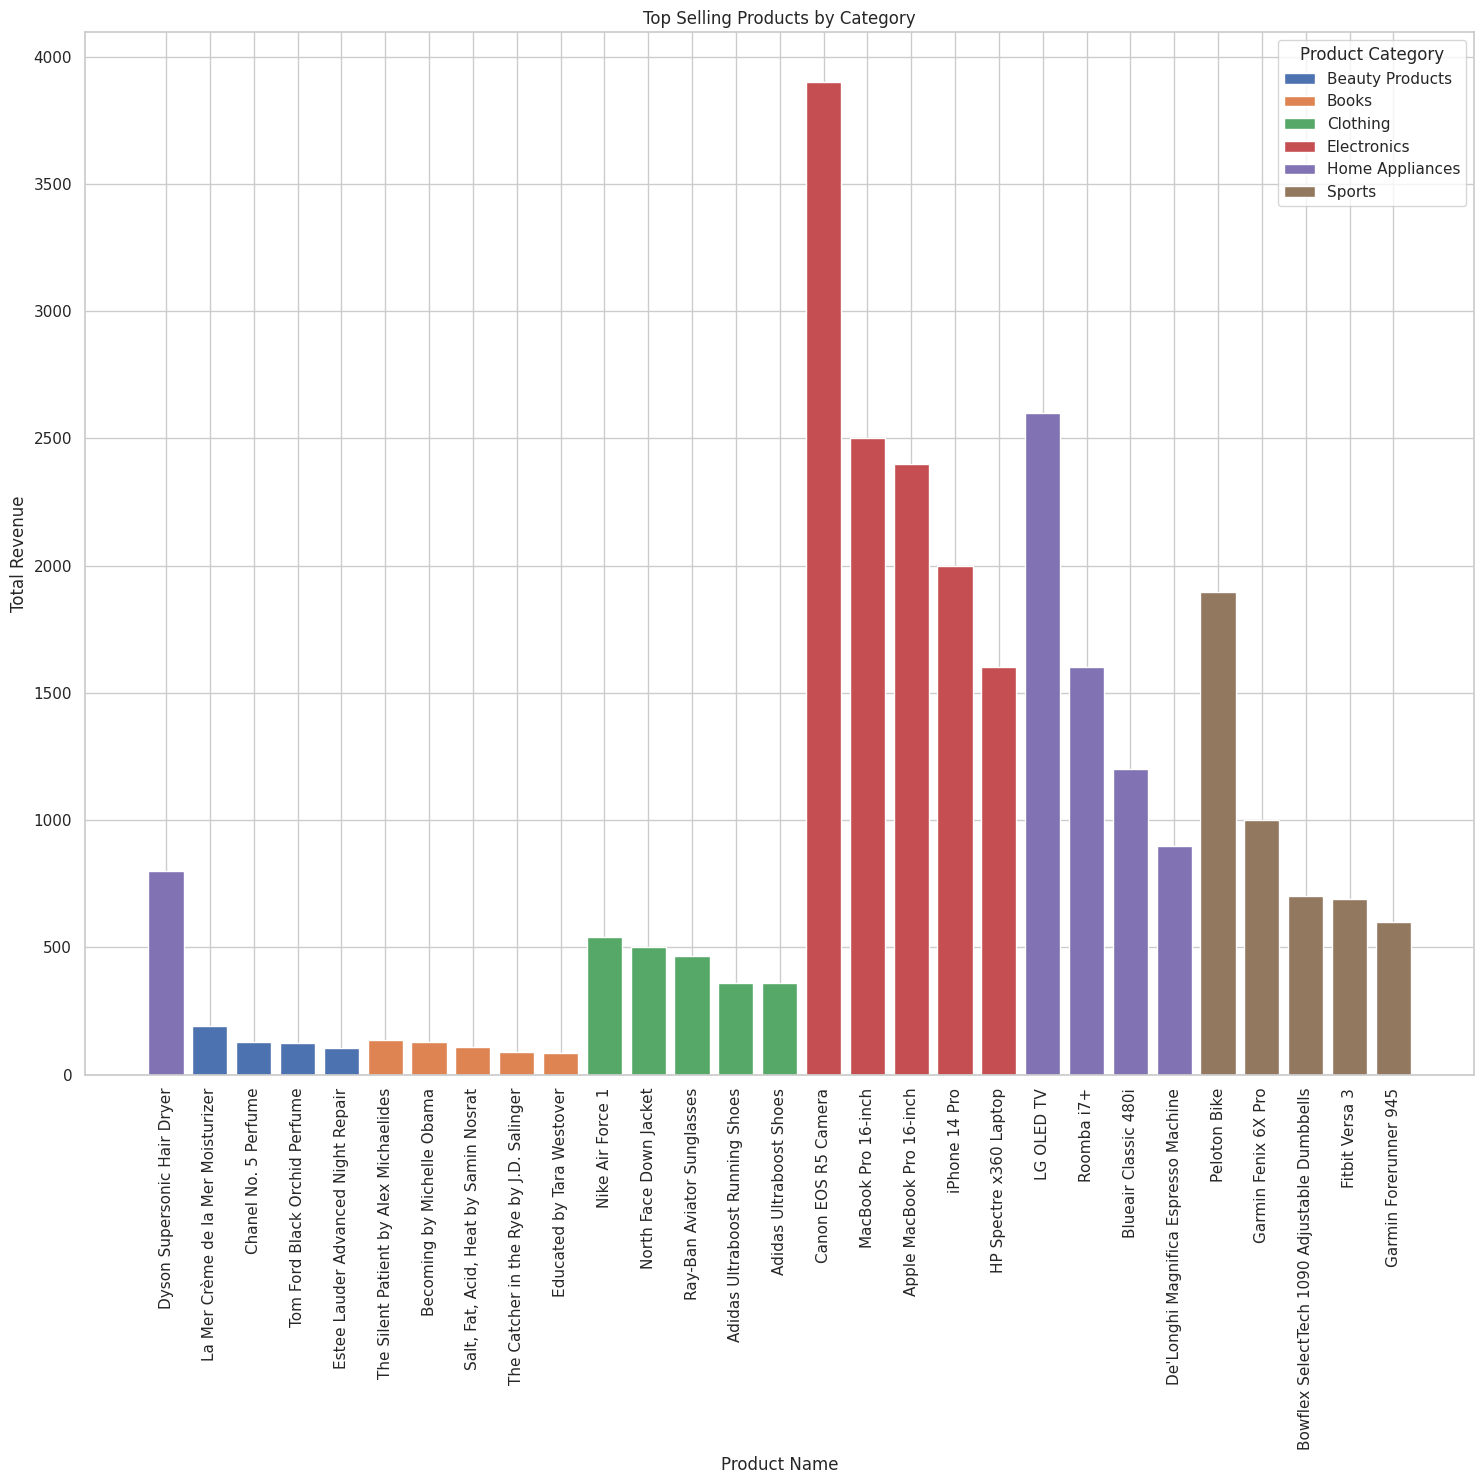

In [18]:
sales_by_category_product = df.groupby(['Product Category', 'Product Name'])['Total Revenue'].sum().reset_index()
sales_by_category_product_sorted = sales_by_category_product.sort_values(by=['Product Category', 'Total Revenue'], ascending=[True, False])
top_selling_products_by_category = sales_by_category_product_sorted.groupby('Product Category').head(5)

plt.figure(figsize=(15, 15))
for category, data in top_selling_products_by_category.groupby('Product Category'):
    plt.bar(data['Product Name'], data['Total Revenue'], label=category)

plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.title('Top Selling Products by Category')
plt.xticks(rotation=90)
plt.legend(title='Product Category')
plt.tight_layout()
plt.show()

* Highest Sales in the Technology Category: The technology category records the highest sales in the analyzed period. This suggests a strong demand for technological products such as electronic devices, computer equipment, and related accessories.

* Second-Highest Sales Category - Home Appliances: After technology, the home appliances category registers the second-highest level of sales. This indicates that consumers also show significant interest in home products such as kitchen appliances, cleaning devices, and household equipment.

* Sales in Sports Products: Although sales in the sports category are lower compared to technology and home appliances, they remain significant. This suggests sustained demand for sports-related products such as sportswear, exercise equipment, and outdoor activity accessories.

In summary, the analysis of sales by category indicates that technology leads in terms of sales, closely followed by home appliances and then sports products. This information can be valuable for making strategic decisions regarding inventory, marketing, and product development in each of these categories.

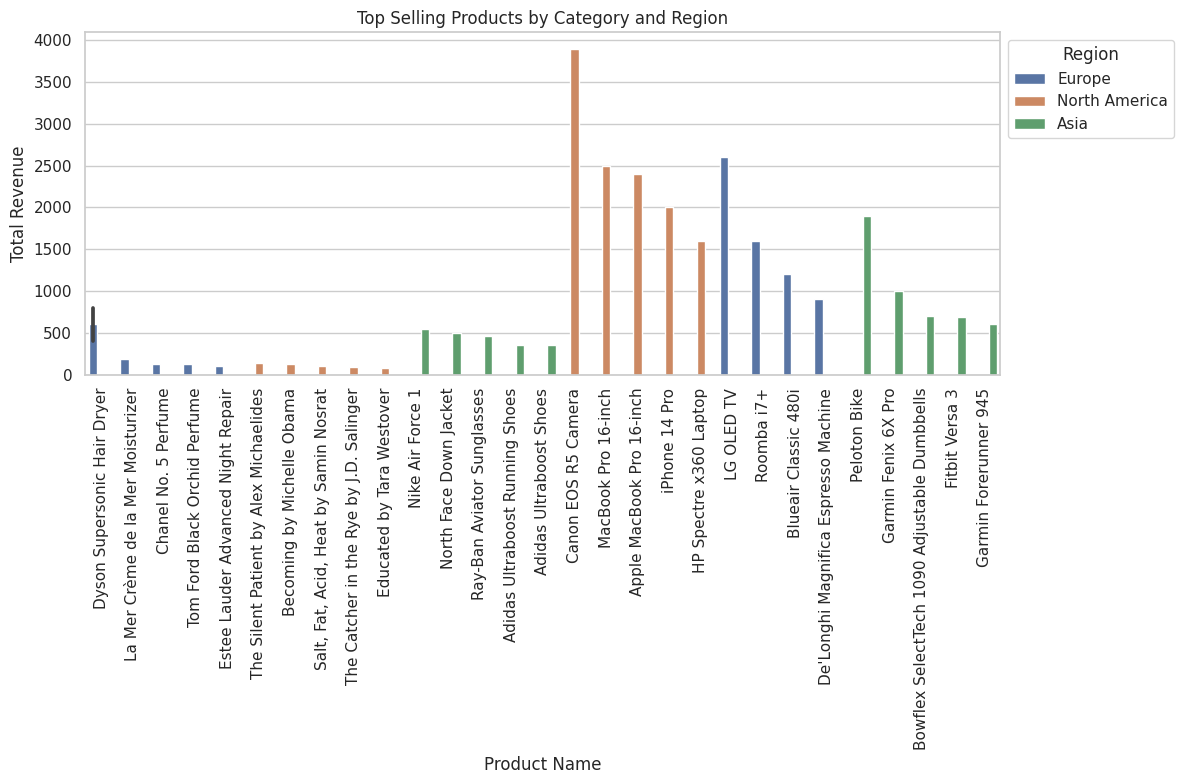

In [19]:
sales_by_category_region = df.groupby(['Product Category', 'Region', 'Product Name'])['Total Revenue'].sum().reset_index()
sales_by_category_region_sorted = sales_by_category_region.sort_values(by=['Product Category', 'Region', 'Total Revenue'], ascending=[True, True, False])
top_selling_products_by_category_region = sales_by_category_region_sorted.groupby(['Product Category', 'Region']).head(5)


plt.figure(figsize=(12, 8))
sns.barplot(data=top_selling_products_by_category_region, x='Product Name', y='Total Revenue', hue='Region', dodge=True)
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.title('Top Selling Products by Category and Region')
plt.xticks(rotation=90)
plt.legend(title='Region', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


* Strong Economy and High Purchasing Power: The United States has one of the largest economies in the world and a high level of purchasing power among its citizens. This means that many people have the financial resources to invest in technological products such as smartphones, computers, and electronic devices.

* Culture of Innovation and Consumption: The United States has a culture that values innovation and the consumption of new and cutting-edge products. American technology companies like Apple, Google, and Microsoft are global leaders in developing innovative technology, and American consumers often quickly adopt new technological products and trends.

* Access to Technology and Connectivity: Overall, there is widespread access to technology and connectivity in the United States. Telecommunications infrastructure and access to high-speed internet are widespread, making it easy for consumers to use and adopt a wide range of technological devices and services.

* Wide Variety of Products and Competitive Market: The technology market in the United States is highly competitive and offers a wide variety of products to meet the needs and preferences of consumers. From smartphones and tablets to smart home devices and streaming content services, there are plenty of options available to American consumers.

In summary, the combination of a strong economy, a culture of technology consumption, widespread access to technology, and a competitive market contributes to making the United States one of the leading consumers of technology worldwide.